In [211]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from glob import glob
from sklearn.decomposition import PCA
from os.path import exists, join
from mpl_toolkits.basemap import Basemap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from hagelslag.evaluation import DistributedReliability, ContingencyTable

In [23]:
data_path = "/glade/scratch/dgagne/ci_hackathon_2017/"
lme_file_template = "b.e11.BLMTRC5CN.f19_g16.{0:03d}.cam.h0.{1:s}.085012-200412.nc"
precip_file_template = "DJF_precip_lme_cam_{0:03d}_PRECT_0851-2005.csv"

In [5]:
ds = xr.open_dataset(join(data_path, lme_file_template.format(2, "PSL")))
psl_data = ds["PSL"]

/glade/p/work/dgagne/miniconda/envs/hail/lib/python3.5/site-packages/xarray/conventions.py:393: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/glade/p/work/dgagne/miniconda/envs/hail/lib/python3.5/site-packages/xarray/conventions.py:412: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


In [378]:
test_ds = xr.open_dataset(join(data_path, lme_file_template.format(8, "PSL")))
test_psl_data = ds["PSL"].values

/glade/p/work/dgagne/miniconda/envs/hail/lib/python3.5/site-packages/xarray/conventions.py:393: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/glade/p/work/dgagne/miniconda/envs/hail/lib/python3.5/site-packages/xarray/conventions.py:412: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


In [43]:
precip_data = []
for ens in range(2, 14):
    precip_data.append(pd.read_csv(join(data_path, precip_file_template.format(ens)), 
                                   names=["Year", "Precip_{0:02d}".format(ens)], index_col="Year"))
all_precip_data = pd.concat(precip_data,axis=1)

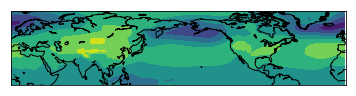

In [52]:
bmap = Basemap(projection="cyl", lon_0=180, llcrnrlat=0, llcrnrlon=0, urcrnrlon=359, urcrnrlat=80)
bmap.drawcoastlines()
plt.contourf(psl_data["lon"],psl_data["lat"][psl_data["lat"] > 0], psl_data[0, psl_data["lat"] > 0])

In [15]:
psl_data["lat"] 

<xarray.DataArray 'lat' (lat: 96)>
array([-90.      , -88.105263, -86.210526, -84.315789, -82.421053, -80.526316,
       -78.631579, -76.736842, -74.842105, -72.947368, -71.052632, -69.157895,
       -67.263158, -65.368421, -63.473684, -61.578947, -59.684211, -57.789474,
       -55.894737, -54.      , -52.105263, -50.210526, -48.315789, -46.421053,
       -44.526316, -42.631579, -40.736842, -38.842105, -36.947368, -35.052632,
       -33.157895, -31.263158, -29.368421, -27.473684, -25.578947, -23.684211,
       -21.789474, -19.894737, -18.      , -16.105263, -14.210526, -12.315789,
       -10.421053,  -8.526316,  -6.631579,  -4.736842,  -2.842105,  -0.947368,
         0.947368,   2.842105,   4.736842,   6.631579,   8.526316,  10.421053,
        12.315789,  14.210526,  16.105263,  18.      ,  19.894737,  21.789474,
        23.684211,  25.578947,  27.473684,  29.368421,  31.263158,  33.157895,
        35.052632,  36.947368,  38.842105,  40.736842,  42.631579,  44.526316,
        46.421053

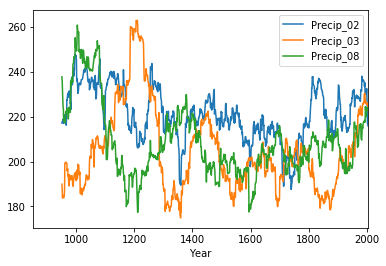

In [277]:
all_precip_data[["Precip_02", "Precip_03", "Precip_08"]].rolling(100).std().plot()

In [257]:
#valid_lats = (psl_data["lat"] > 0) & (psl_data["lat"] < 80)
all_psl_data = psl_data[:, :, :].values
all_test_psl_data = test_psl_data[:, :, :].values

In [352]:
norm_psl_data = (all_psl_data - all_psl_data.mean(axis=0))/ all_psl_data.std(axis=0)
test_norm_psl_data = (all_test_psl_data- all_psl_data.mean(axis=0))/ all_psl_data.std(axis=0)

In [61]:
norm_psl_data.shape

(1155, 42, 144)

In [353]:
pc = PCA(n_components=10)
pc_psl_data = pc.fit_transform(norm_psl_data.reshape(-1, np.prod(norm_psl_data.shape[1:])))
test_pc_psl_data = pc.transform(test_norm_psl_data.reshape(-1, np.prod(norm_psl_data.shape[1:])))

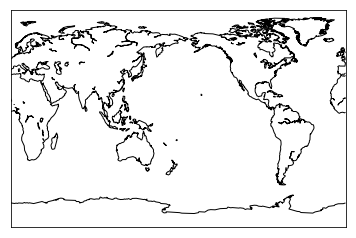

In [182]:
bmap = Basemap(projection="cyl", lon_0=180, llcrnrlat=-90, llcrnrlon=0, urcrnrlon=359, urcrnrlat=90, fix_aspect=False)
bmap.drawcoastlines()

In [79]:
pc.components_.max()

0.064856982030846375

In [354]:
lr = LogisticRegression(penalty="l2")
train_labels = np.where(all_precip_data["Precip_02"] >= all_precip_data["Precip_02"].mean(), 1, 0)
lr.fit(pc_psl_data, train_labels)
coef_order = np.argsort(np.abs(lr.coef_[0]))[::-1]

In [359]:
pc.components_.max()

0.036776853822978607

In [184]:
coef_order

array([5, 9, 4, 6, 8, 3, 2, 7, 0, 1])

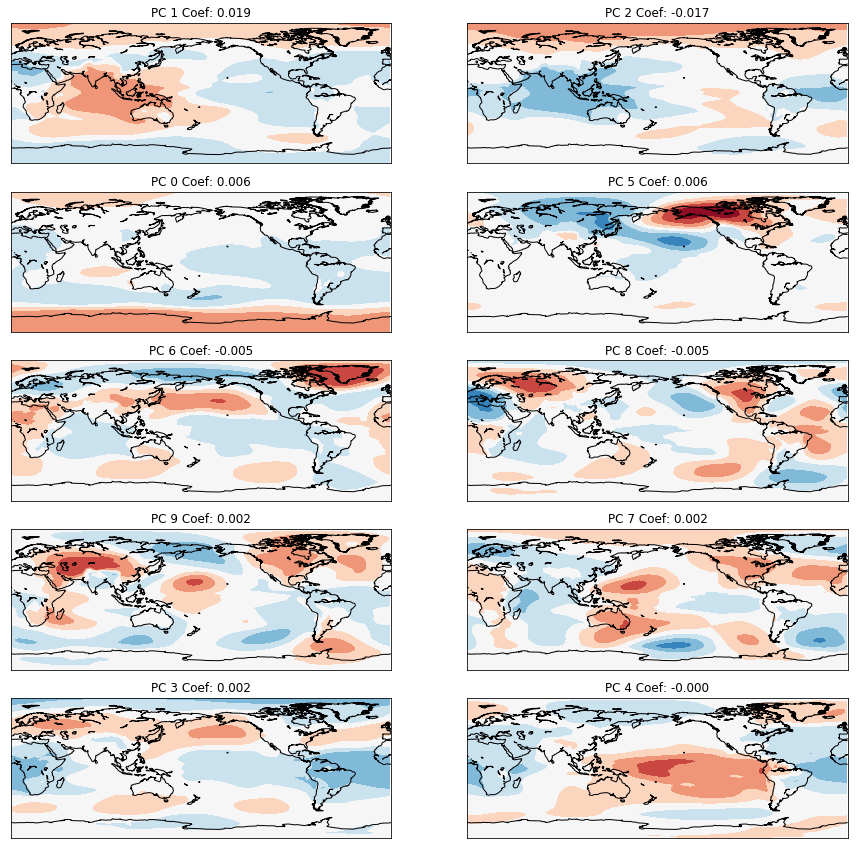

In [360]:
fig, axes = plt.subplots(5, 2, figsize=(15, 15))
a = 0
for (i, j), ax in np.ndenumerate(axes):
    bmap.drawcoastlines(ax=ax)
    ax.contourf(psl_data["lon"], psl_data["lat"], 
                pc.components_[coef_order[a]].reshape(norm_psl_data.shape[1:]), np.linspace(-0.04, 0.04, 10), cmap="RdBu_r")
    ax.set_title("PC {0:d} Coef: {1:0.3f}".format(coef_order[a], lr.coef_[0][coef_order[a]]))
    a += 1

In [362]:
rf = RandomForestClassifier(n_estimators=100, max_features="sqrt")
rf.fit(pc_psl_data, np.where(all_precip_data["Precip_02"] >= all_precip_data["Precip_02"].mean(), 1, 0))
var_imp_rankings = np.argsort(rf.feature_importances_)[::-1]

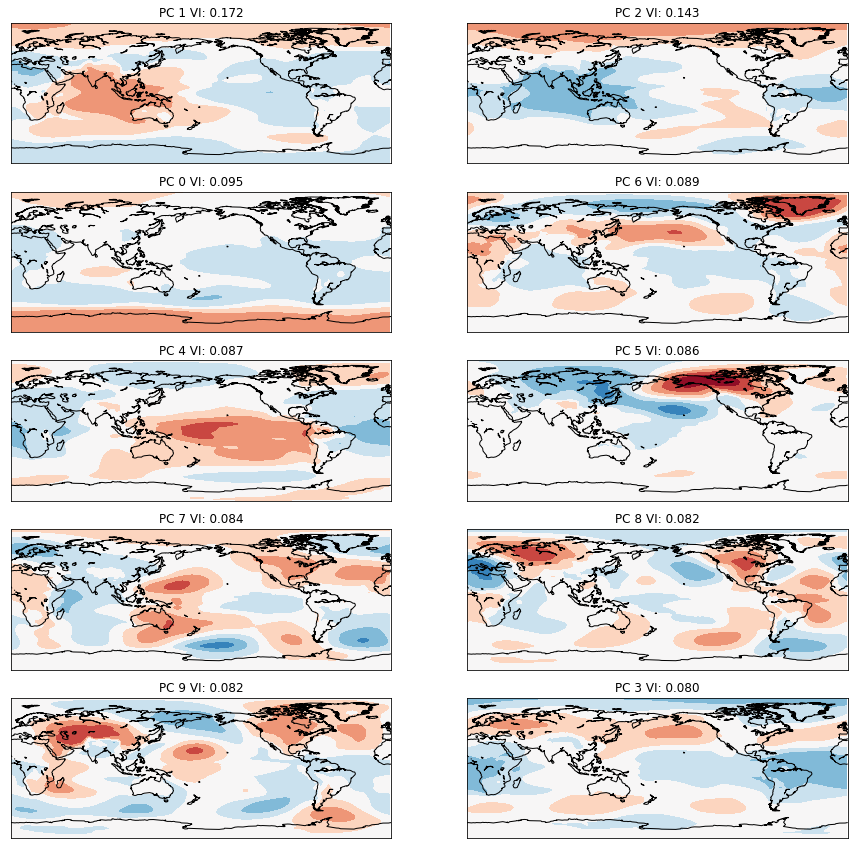

In [363]:
fig, axes = plt.subplots(5, 2, figsize=(15, 15))
a = 0
for (i, j), ax in np.ndenumerate(axes):
    bmap.drawcoastlines(ax=ax)
    ax.contourf(psl_data["lon"], psl_data["lat"], 
                pc.components_[var_imp_rankings[a]].reshape(norm_psl_data.shape[1:]), np.linspace(-0.04, 0.04, 10), cmap="RdBu_r")
    ax.set_title("PC {0:d} VI: {1:0.3f}".format(var_imp_rankings[a], rf.feature_importances_[var_imp_rankings[a]]))
    a += 1

In [368]:
preds = pd.DataFrame({"Logistic": lr.predict_proba(test_pc_psl_data)[:, 1],
                      "Random Forest": rf.predict_proba(test_pc_psl_data)[:, 1],
                      "RF Norm": rf_norm.predict_proba(test_norm_psl_data.reshape(-1, np.prod(test_norm_psl_data.shape[1:])))[:, 1]})
d_preds = pd.DataFrame({"Logistic": lr.predict(test_pc_psl_data),
                      "Random Forest": rf.predict(test_pc_psl_data),
                      "RF Norm": rf_norm.predict(test_norm_psl_data.reshape(-1, np.prod(test_norm_psl_data.shape[1:])))})

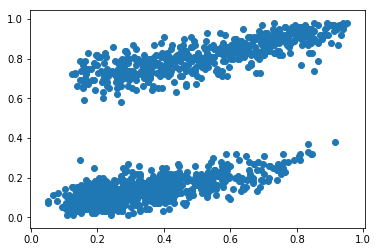

In [369]:
plt.scatter(preds["Logistic"], preds["Random Forest"])

(array([ 162.,  371.,  122.,    5.,    0.,    0.,    7.,  107.,  267.,  114.]),
 array([ 0.01 ,  0.104,  0.198,  0.292,  0.386,  0.48 ,  0.574,  0.668,
         0.762,  0.856,  0.95 ]),
 <a list of 10 Patch objects>)

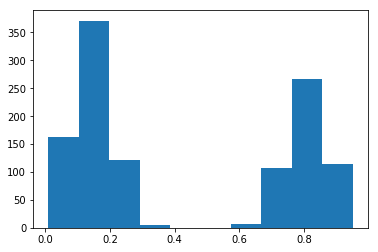

In [126]:
pre

In [371]:
test_labels = np.where(all_precip_data["Precip_08"] >= all_precip_data["Precip_02"].mean(), 1, 0)

In [372]:
for col in preds.columns:
    print(col, np.mean((preds[col] - test_labels) ** 2))
print("Climo", np.mean((train_labels.mean() - test_labels) ** 2))

Logistic 0.28472081154129175
RF Norm 0.36722294372294373
Random Forest 0.36452233766233794
Climo 0.243784786642


In [208]:
test_labels.mean() - test_labels

array([-0.59480519, -0.59480519,  0.40519481, ...,  0.40519481,
        0.40519481, -0.59480519])

In [366]:
rf_norm = RandomForestClassifier(n_estimators=100, max_features="sqrt")
rf_norm.fit(norm_psl_data.reshape(-1, np.prod(norm_psl_data.shape[1:])), train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

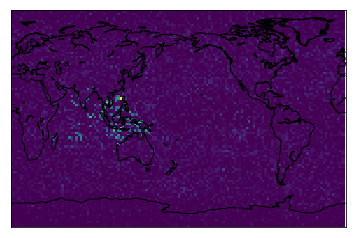

In [367]:
bmap.drawcoastlines()
plt.pcolormesh(psl_data["lon"], psl_data["lat"], rf_norm.feature_importances_.reshape(norm_psl_data.shape[1:]))

Index(['Bin_Start', 'Bin_End', 'Bin_Center', 'Positive_Relative_Freq',
       'Total_Relative_Freq'],
      dtype='object')


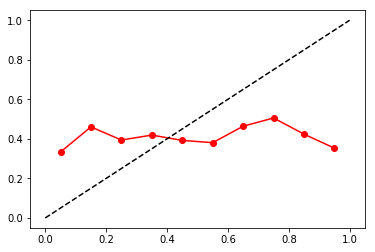

In [373]:
dr = DistributedReliability(thresholds=np.arange(0, 1.2, 0.1))
dr.update(preds["Logistic"], test_labels)
rel_curve = dr.reliability_curve()
print(rel_curve.columns)
plt.plot(rel_curve["Bin_Center"], rel_curve["Positive_Relative_Freq"], 'ro-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k--')

In [374]:
for col in d_preds.columns:
    tp = np.count_nonzero((d_preds[col] == 1) & (test_labels == 1))
    fp = np.count_nonzero((d_preds[col] == 1) & (test_labels == 0))    
    fn = np.count_nonzero((d_preds[col] == 0) & (test_labels == 1))
    tn = np.count_nonzero((d_preds[col] == 0) & (test_labels == 0))
    ct = ContingencyTable(tp, fp, fn, tn)
    print(col, ct.ets())

Logistic 0.0101739949058
RF Norm -0.00227272727273
Random Forest -0.00227272727273


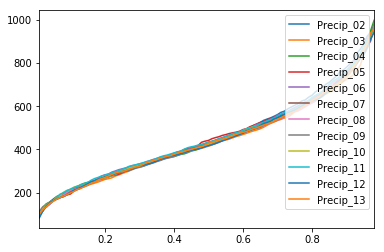

In [375]:
all_precip_data.quantile(q=np.arange(0.01, 0.99, 0.01)).plot()

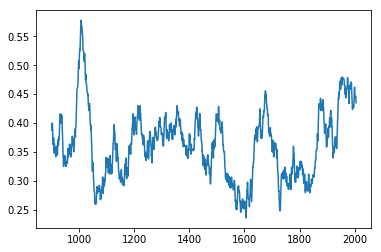

In [376]:
plt.plot(all_precip_data.index, ((preds["Random Forest"] - test_labels) ** 2).rolling(50).mean())

In [322]:
precip_rankings = all_precip_data["Precip_02"].values.argsort()

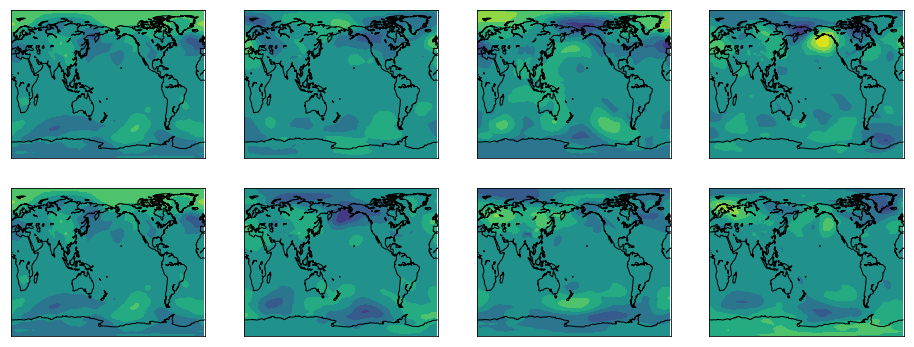

In [333]:
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
for a, ax in enumerate(axes[0]):
    bmap.drawcoastlines(ax=ax)
    ax.contourf(psl_data["lon"], psl_data["lat"], 
                (all_psl_data[precip_rankings[-a]]-all_psl_data.mean(axis=0))/100, np.linspace(-20, 20, 10))
for a, ax in enumerate(axes[1]):
    bmap.drawcoastlines(ax=ax)
    ax.contourf(psl_data["lon"], psl_data["lat"], 
                (all_psl_data[precip_rankings[a]]-all_psl_data.mean(axis=0))/100, np.linspace(-20, 20, 10))

In [329]:
((all_psl_data[precip_rankings[-a]]-all_psl_data.mean(axis=0))/100).min()

-14.849218

In [382]:
o_norm_pres = test_psl_data[all_precip_data["Precip_08"] > all_precip_data["Precip_08"].mean()] - test_psl_data.mean(axis=0)
u_norm_pres = test_psl_data[all_precip_data["Precip_08"] < all_precip_data["Precip_08"].mean()] - test_psl_data.mean(axis=0)

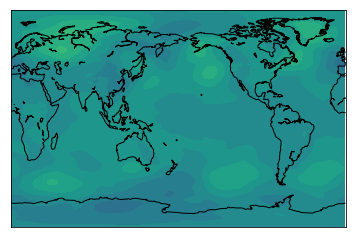

In [383]:
bmap.drawcoastlines()
plt.contourf(psl_data["lon"], psl_data["lat"], o_norm_pres.mean(axis=0), np.arange(-100, 110, 10))

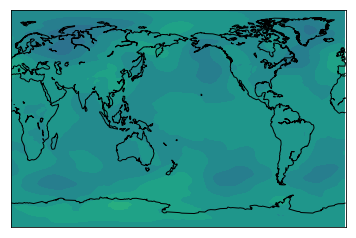

In [384]:
bmap.drawcoastlines()
plt.contourf(psl_data["lon"], psl_data["lat"], u_norm_pres.mean(axis=0), np.arange(-100, 110, 10))

In [343]:
u_norm_pres.mean(axis=0).min()

-82.558868

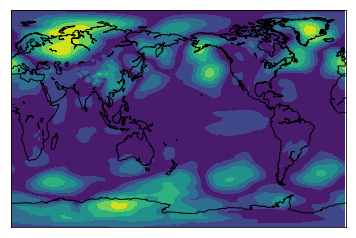

In [385]:
bmap.drawcoastlines()
plt.contourf(psl_data["lon"], psl_data["lat"], np.abs(o_norm_pres.mean(axis=0) - u_norm_pres.mean(axis=0)))